In [ ]:
# Check Java version (Colab includes OpenJDK 11)
!java -version

# Install PySpark (already installed but safe to rerun)
!pip install pyspark --quiet

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64" # Changed to Java 17 path

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("ColabPySpark") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.5-s_2.12")\
    .getOrCreate()

spark

openjdk version "17.0.16" 2025-07-15
OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1)
OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)


In [ ]:
housing = spark.read.csv('/content/final_df.csv',header=True,inferSchema=True)

In [ ]:
housing.show()

+-------------------------+--------------------+---------+---------+------+-----------+-----------------------+
|Date of Sale (dd/mm/yyyy)|             Address|  Price_2|     town|County|urban_rural|Description of Property|
+-------------------------+--------------------+---------+---------+------+-----------+-----------------------+
|               07/12/2015|20 College Woods,...|  69500.0|    balla|  mayo|      urban|   New Dwelling hous...|
|               30/01/2015|       Prizon, Balla| 115000.0|    balla|  mayo|      urban|   New Dwelling hous...|
|               21/11/2017|30, COLLEGE WOODS...|  61232.0|    balla|  mayo|      urban|   New Dwelling hous...|
|               10/03/2017|19 College Woods,...|  69500.0|    balla|  mayo|      urban|   New Dwelling hous...|
|               14/06/2016|25 College Woods,...|  61232.0|    balla|  mayo|      urban|   New Dwelling hous...|
|               12/07/2016| 44 ardcronan, Balla|  64316.0|    balla|  mayo|      urban|   New Dwelling h

In [ ]:
from pyspark.sql import functions as F

housing = housing.withColumn(
    "town_county",
    F.concat_ws(", ", F.col("town"), F.col("County"))
)


In [ ]:
housing.show()

+-------------------------+--------------------+---------+---------+------+-----------+-----------------------+-----------------+
|Date of Sale (dd/mm/yyyy)|             Address|  Price_2|     town|County|urban_rural|Description of Property|      town_county|
+-------------------------+--------------------+---------+---------+------+-----------+-----------------------+-----------------+
|               07/12/2015|20 College Woods,...|  69500.0|    balla|  mayo|      urban|   New Dwelling hous...|      balla, mayo|
|               30/01/2015|       Prizon, Balla| 115000.0|    balla|  mayo|      urban|   New Dwelling hous...|      balla, mayo|
|               21/11/2017|30, COLLEGE WOODS...|  61232.0|    balla|  mayo|      urban|   New Dwelling hous...|      balla, mayo|
|               10/03/2017|19 College Woods,...|  69500.0|    balla|  mayo|      urban|   New Dwelling hous...|      balla, mayo|
|               14/06/2016|25 College Woods,...|  61232.0|    balla|  mayo|      urban|   

In [ ]:
housing.columns

['Date of Sale (dd/mm/yyyy)',
 'Address',
 'Price_2',
 'town',
 'County',
 'urban_rural',
 'Description of Property',
 'town_county']

In [ ]:
# using median house prices per year create a line graph to show house pricess increasing/decreasing over time

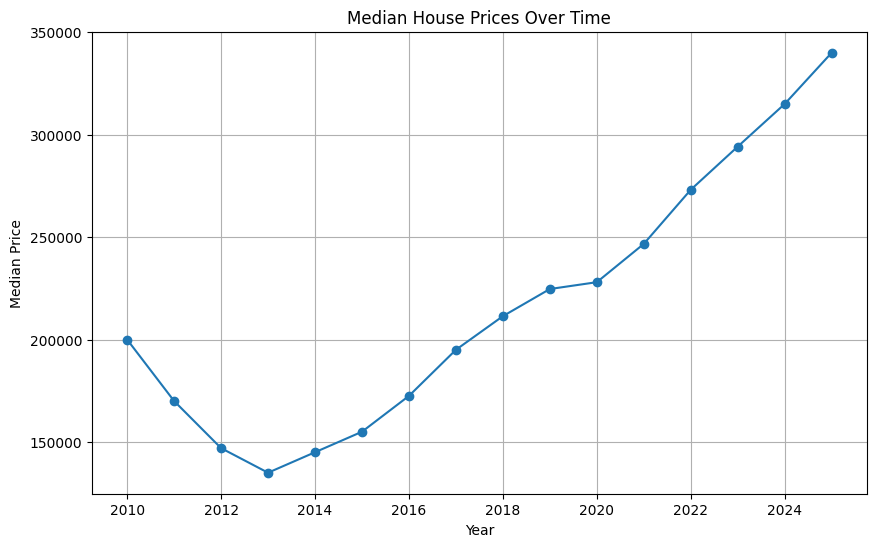

In [ ]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Convert string date to proper date type
housing = housing.withColumn(
    "SaleDate",
    F.to_date("Date of Sale (dd/mm/yyyy)", "dd/MM/yyyy")
)

#year
housing = housing.withColumn("Year", F.year("SaleDate"))

# median prices per year
median_prices_df = (
    housing.groupBy("Year")
           .agg(F.expr('percentile_approx(Price_2, 0.5)').alias("MedianPrice"))
           .orderBy("Year")
)


median_prices_pd = median_prices_df.toPandas()
plt.figure(figsize=(10,6))
plt.plot(median_prices_pd["Year"], median_prices_pd["MedianPrice"], marker='o')
plt.title("Median House Prices Over Time")
plt.xlabel("Year")
plt.ylabel("Median Price")
plt.grid(True)
plt.show()


In [ ]:
# median prices per country:
from pyspark.sql import functions as F

county_prices = (
    housing.groupBy("County")
           .agg(F.expr("percentile_approx(Price_2, 0.5)").alias("MedianPrice"))
           .orderBy("MedianPrice", ascending=False)
)
top_5=county_prices.limit(5)
bottom5 = county_prices.orderBy("MedianPrice", ascending=True).limit(5)
county_prices.show()

top_5.show()

bottom5.show()


+---------+-----------+
|   County|MedianPrice|
+---------+-----------+
|   dublin|  361233.48|
|  wicklow|   325000.0|
|  kildare|   285000.0|
|    meath|   260000.0|
|     cork|   225000.0|
|   galway|   207000.0|
|    louth|   200000.0|
| kilkenny|   190000.0|
| limerick|   180000.0|
|  wexford|   175000.0|
|    laois|   170000.0|
|westmeath|   170000.0|
|waterford|   170000.0|
|    kerry|   165000.0|
|    clare|   164000.0|
|   carlow|   163000.0|
|   offaly|   158500.0|
|tipperary|   148000.0|
| monaghan|   142000.0|
|    sligo|   140000.0|
+---------+-----------+
only showing top 20 rows

+-------+-----------+
| County|MedianPrice|
+-------+-----------+
| dublin|  361233.48|
|wicklow|   325000.0|
|kildare|   285000.0|
|  meath|   260000.0|
|   cork|   225000.0|
+-------+-----------+

+---------+-----------+
|   County|MedianPrice|
+---------+-----------+
| longford|   105000.0|
|roscommon|   110000.0|
|  leitrim|   110000.0|
|  donegal|   119050.0|
|    cavan|   135000.0|
+------

In [ ]:
from pyspark.sql import functions as F

town_counts = (
    housing.groupBy("town_county")
           .agg(F.count("*").alias("Count"))
)


In [ ]:
valid_towns = town_counts.filter(F.col("Count") > 1)


In [ ]:
town_prices = (
    housing.join(valid_towns, on="town_county", how="inner")
           .groupBy("town_county")
           .agg(
                F.expr("percentile_approx(Price_2, 0.5)").alias("MedianPrice"),
                F.first("Count").alias("NumSales")
           )
           .orderBy("MedianPrice", ascending=False)
)


In [ ]:
top5 = town_prices.limit(5)
top5.show()

bottom5 = town_prices.orderBy("MedianPrice", ascending=True).limit(5)
bottom5.show()


+-------------------+-----------+--------+
|        town_county|MedianPrice|NumSales|
+-------------------+-----------+--------+
|caherdaniel, dublin|  3471366.0|       2|
|   rathmore, dublin|  2750000.0|       3|
|   drumkeen, dublin|  2100000.0|       2|
|      malin, dublin|  1321586.0|       2|
|    melmore, dublin|  1100000.0|       2|
+-------------------+-----------+--------+

+--------------------+-----------+--------+
|         town_county|MedianPrice|NumSales|
+--------------------+-----------+--------+
|coalbrook, tipperary|    10000.0|       2|
|     toomard, galway|    10000.0|       2|
|kilmanahan, kilkenny|    15000.0|       2|
|    clondulane, cork|    15000.0|       2|
|tory island, donegal|    16000.0|       3|
+--------------------+-----------+--------+



In [ ]:
# median prices per town:

from pyspark.sql import functions as F

# Median price for each town_county
town_prices = (
    housing.groupBy("County", "town")
           .agg(F.expr("percentile_approx(Price_2, 0.5)").alias("MedianPrice"))
           .orderBy("MedianPrice", ascending=False)
)

town_prices.show()



+---------+-----------+-----------+
|   County|       town|MedianPrice|
+---------+-----------+-----------+
|   dublin|   clonmore|  8100000.0|
|    clare|    kinsale|  5080000.0|
|    meath|castleknock|  4000000.0|
|   dublin|caherdaniel|  3471366.0|
|tipperary|  tullamore| 3242290.75|
|   dublin|   glenmore|  3200000.0|
|   dublin|    doonbeg|  3200000.0|
|  kildare|     dingle|  3019315.0|
|   dublin|   clogheen|  2765000.0|
|   dublin|   rathmore|  2750000.0|
|   dublin|  kilfenora|  2675000.0|
|   dublin|   drumkeen|  2100000.0|
|   dublin|   glandore|  2100000.0|
|   dublin| ravensdale|  2040000.0|
|   dublin|  lisronagh|  1750000.0|
|   dublin|    annamoe|  1740000.0|
|   dublin|      elton|  1560000.0|
|  kildare|    ardfert| 1503436.12|
|   dublin|     beltra|  1450000.0|
|   dublin| ballinglen|  1365000.0|
+---------+-----------+-----------+
only showing top 20 rows



In [ ]:
from pyspark.sql import functions as F



county_year_medians = (
    housing.groupBy("County", "Year")
           .agg(F.expr("percentile_approx(Price_2, 0.5)").alias("MedianPrice"))
)

#First and last year per County
year_bounds = (
    county_year_medians.groupBy("County")
                       .agg(
                           F.min("Year").alias("StartYear"),
                           F.max("Year").alias("EndYear")
                       )
)

# start median
start_df = (
    county_year_medians.join(year_bounds, on="County")
                       .where(F.col("Year") == F.col("StartYear"))
                       .select(
                           "County",
                           "StartYear",
                           F.col("MedianPrice").alias("StartMedianPrice")
                       )
)

# end year median
end_df = (
    county_year_medians.join(year_bounds, on="County")
                       .where(F.col("Year") == F.col("EndYear"))
                       .select(
                           "County",
                           "EndYear",
                           F.col("MedianPrice").alias("EndMedianPrice")
                       )
)

# 6) Join start & end + compute NumYears and Growth %
growth_df = (
    start_df.join(end_df, on="County")
            .withColumn("NumYears", F.col("EndYear") - F.col("StartYear"))
            .filter(F.col("NumYears") > 0)  # drop counties with only 1 year
            .withColumn(
                "GrowthPct",
                (F.col("EndMedianPrice") - F.col("StartMedianPrice"))
                / F.col("StartMedianPrice") * 100
            )
)

# columns i want displayed
result = (
    growth_df.select(
        "County",
        "StartYear",
        F.round("StartMedianPrice", 0).alias("StartMedianPrice"),
        "EndYear",
        F.round("EndMedianPrice", 0).alias("EndMedianPrice"),
        "NumYears",
        F.round("GrowthPct", 2).alias("GrowthPct")
    )
)

result.show()

# Top 5 fastest growth
top5 = result.orderBy(F.col("GrowthPct").desc()).limit(5)
top5.show()

# Bottom 5 slowest growth
bottom5 = result.orderBy(F.col("GrowthPct").asc()).limit(5)
bottom5.show()


+---------+---------+----------------+-------+--------------+--------+---------+
|   County|StartYear|StartMedianPrice|EndYear|EndMedianPrice|NumYears|GrowthPct|
+---------+---------+----------------+-------+--------------+--------+---------+
|   carlow|     2010|        149000.0|   2025|      256000.0|      15|    71.81|
|    cavan|     2010|        132159.0|   2025|      237800.0|      15|    79.93|
|    clare|     2010|        160000.0|   2025|      290000.0|      15|    81.25|
|     cork|     2010|        197500.0|   2025|      325991.0|      15|    65.06|
|  donegal|     2010|        132500.0|   2025|      177500.0|      15|    33.96|
|   dublin|     2010|        277000.0|   2025|      497797.0|      15|    79.71|
|   galway|     2010|        197500.0|   2025|      338000.0|      15|    71.14|
|    kerry|     2010|        175000.0|   2025|      275000.0|      15|    57.14|
|  kildare|     2010|        227500.0|   2025|      400881.0|      15|    76.21|
| kilkenny|     2010|       

In [ ]:
from pyspark.sql import functions as F


#  Count number of sales per town per year

year_counts = (
    housing.groupBy("town_county", "Year")
           .agg(F.count("*").alias("YearCount"))
)


#  median price per town per year

town_year_medians = (
    housing.groupBy("town_county", "urban_rural", "Year")
           .agg(F.expr("percentile_approx(Price_2, 0.5)").alias("MedianPrice"))
)


# Start and end year for each town_county

bounds = (
    town_year_medians.groupBy("town_county")
                     .agg(
                         F.min("Year").alias("StartYear"),
                         F.max("Year").alias("EndYear")
                     )
)

# Start year median + start-year count

start_df = (
    town_year_medians.join(bounds, "town_county")
                     .where(F.col("Year") == F.col("StartYear"))
                     .join(year_counts, ["town_county", "Year"])
                     .select(
                         "town_county",
                         "urban_rural",
                         "StartYear",
                         F.col("YearCount").alias("StartYearCount"),
                         F.col("MedianPrice").alias("StartMedianPrice")
                     )
)


# End year median + end-year count

end_df = (
    town_year_medians.join(bounds, "town_county")
                     .where(F.col("Year") == F.col("EndYear"))
                     .join(year_counts, ["town_county", "Year"])
                     .select(
                         "town_county",
                         "EndYear",
                         F.col("YearCount").alias("EndYearCount"),
                         F.col("MedianPrice").alias("EndMedianPrice")
                     )
)


# Combine start + end + compute inflation
# Only keep towns with > 5 sales in BOTH start + end year

growth = (
    start_df.join(end_df, "town_county")
            .withColumn("NumYears", F.col("EndYear") - F.col("StartYear"))
            .filter(F.col("NumYears") > 0)
            .filter(F.col("StartYearCount") > 5)   # new condition
            .filter(F.col("EndYearCount") > 5)     # new condition
            .withColumn(
                "GrowthPct",
                (F.col("EndMedianPrice") - F.col("StartMedianPrice"))
                / F.col("StartMedianPrice") * 100
            )
)


# display columns

result = growth.select(
    "town_county",
    "urban_rural",
    "StartYear",
    "StartYearCount",
    F.round("StartMedianPrice", 0).alias("StartMedianPrice"),
    "EndYear",
    "EndYearCount",
    F.round("EndMedianPrice", 0).alias("EndMedianPrice"),
    "NumYears",
    F.round("GrowthPct", 2).alias("GrowthPct")
)

result.show(truncate=False)


#  Top 5 URBAN towns

top5_urban = (
    result.filter(F.col("urban_rural") == "urban")
          .orderBy(F.col("GrowthPct").desc())
          .limit(5)
)
top5_urban.show(truncate=False)

#  Top 5 RURAL towns

top5_rural = (
    result.filter(F.col("urban_rural") == "rural")
          .orderBy(F.col("GrowthPct").desc())
          .limit(5)
)
top5_rural.show(truncate=False)


+--------------------+-----------+---------+--------------+----------------+-------+------------+--------------+--------+---------+
|town_county         |urban_rural|StartYear|StartYearCount|StartMedianPrice|EndYear|EndYearCount|EndMedianPrice|NumYears|GrowthPct|
+--------------------+-----------+---------+--------------+----------------+-------+------------+--------------+--------+---------+
|sligo, sligo        |urban      |2010     |68            |135000.0        |2025   |396         |245000.0      |15      |81.48    |
|malin, donegal      |urban      |2010     |6             |114538.0        |2025   |6           |84000.0       |15      |-26.66   |
|bunclody, wexford   |urban      |2010     |13            |150000.0        |2025   |15          |285000.0      |15      |90.0     |
|mallow, cork        |urban      |2010     |90            |170000.0        |2025   |207         |277000.0      |15      |62.94    |
|ballivor, meath     |urban      |2010     |14            |145000.0        |